In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [6]:
anno_df = pd.read_csv(
    DATA_DIR / "celeba" / "CelebAMask-HQ" / "CelebAMask-HQ-attribute-anno.txt",
    header=1,
    delimiter=" ",
)
anno_df["id"] = [int(i[0].split(".")[0]) for i in anno_df.index.values]

In [7]:
hair_types = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bald']
# make a category for hair color
anno_df['hair_category'] = None
for idx, row in tqdm(anno_df.iterrows(), total = len(anno_df)):
    hair_idx = np.where(row[hair_types] == 1)[0]
    if len(hair_idx) == 1:
        anno_df.loc[idx, 'hair_category']= hair_idx[0]
    elif len(hair_idx) > 1: 
        anno_df.loc[idx, 'hair_category']= -1
    else:
        anno_df.loc[idx, 'hair_category']= -2

In [8]:
print(list(anno_df.columns))

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'id', 'hair_category']


In [9]:
faces_128_df = pd.read_pickle(DATA_DIR / 'celeba' / 'faces_128.pickle')

In [10]:
faces_128_df[:3]

,face,id
0,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",20142
1,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",8126
2,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",12655


In [11]:
from skimage.transform import resize

In [12]:
#imgs_64 = [resize(i, (64, 64)) for i in tqdm(faces_128_df.face.values)]

In [13]:
#faces_128_df['face'] = imgs_64

In [14]:
faces_128_df = pd.merge(faces_128_df, anno_df[['id', 'hair_category']], on=['id'])

In [15]:
len(faces_128_df)

30000

In [16]:
faces_128_df['subset'] = 'train'
faces_128_df.loc[0:1000, 'subset'] = 'valid'
faces_128_df.loc[1000:1999, 'subset'] = 'test'

In [17]:
faces_128_df[:3]

,face,id,hair_category,subset
0,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",20142,0,valid
1,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",8126,1,valid
2,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",12655,0,valid


In [18]:
faces_128_df[-1:]

,face,id,hair_category,subset
29999,"[[[64, 64, 64], [64, 64, 64], [64, 64, 64], [6...",17714,0,train


In [19]:
{hair_types[int(i)]:np.sum(faces_128_df['hair_category'] == i) for i in faces_128_df.hair_category.unique() if i in [0, 1,2,3,4]}

{'Black_Hair': 6486, 'Blond_Hair': 4958, 'Bald': 706, 'Brown_Hair': 6657}

In [20]:
Y_train = np.array(list(faces_128_df.hair_category.values[faces_128_df.subset == 'train'])).astype('float32')
Y_valid = np.array(list(faces_128_df.hair_category.values[faces_128_df.subset == 'valid'])).astype('float32')
Y_test = np.array(list(faces_128_df.hair_category.values[faces_128_df.subset == 'test'])).astype('float32')

In [21]:
X_train = np.array(list(faces_128_df.face.values[faces_128_df.subset == 'train'])) / 255.
X_valid = np.array(list(faces_128_df.face.values[faces_128_df.subset == 'valid'])) / 255.
X_test = np.array(list(faces_128_df.face.values[faces_128_df.subset == 'test'])) / 255.

In [22]:
np.array(list(faces_128_df.face.values[faces_128_df.subset == 'train'])).shape

(28000, 128, 128, 3)

In [23]:
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

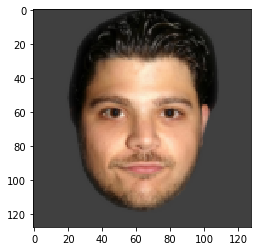

In [24]:
plt.imshow(X_train[0])

In [25]:
X_train_flat.shape, X_valid.shape, X_test.shape

((28000, 49152), (1000, 128, 128, 3), (1000, 128, 128, 3))

### define networks

In [26]:
dims = (128,128,3)
n_components = 512

In [27]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.LocallyConnected2D(
        filters=512, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.LocallyConnected2D(
        filters=512, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [28]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    #tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=2 * 2 * 512, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(2, 2, 512)),
    tf.keras.layers.Conv2D(
        filters=512, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(
        filters=512, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(1, 1), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])

### Create model and train

In [29]:
??tfUMAP

In [30]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=1,
    encoder=encoder,
    decoding_method="autoencoder", 
    decoder=decoder,
    valid_X = X_valid,
    valid_Y = Y_valid,
    dims = dims,
    n_components = n_components,
    batch_size= 100,
)

In [31]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(batch_size=100,
       decoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb6f1c8b860>,
       decoding_method='autoencoder', dims=(128, 128, 3),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fb6f1d4d6d8>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb6f40c37f0>,
       tensorb...
        0., -2.,  0., -2., -2., -2., -2., -2.,  0., -2.,  0.,  2.,  0.,
        1.,  0., -2., -2., -2.,  0.,  2., -2.,  3.,  1.,  0.,  0.,  2.,
        1., -2.,  2., -2.,  0.,  2.,  1., -2.,  1.,  2., -2.,  0., -2.,
        2.,  1.,  1.,  2., -2., -2., -2., -2.,  0., -2.,  2.,  0.,  1.,
        2.,  1., -2., -2.,  0., -2., -2., -2., -2.,  2.,  1., -2., -2.,
       -2.,  1., -2., -2., -2., -2.,  2.,  0., -2.,  3.,  0.,  0., -2.,
       -2.,  0., -2., -2.,  2.,  2., -2., -2.,  2.,  2.,  0.,  1., -2.,
       -2.,  2.,  0.,  0.,  2., -2.,  0.,  0.,  2.,  2.,  0., -2.],
      dtype=fl

W0713 17:27:56.578717 140426742949696 base_layer.py:1790] Layer conv2d is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Mon Jul 13 17:27:56 2020 Finished embedding


### Plot model output

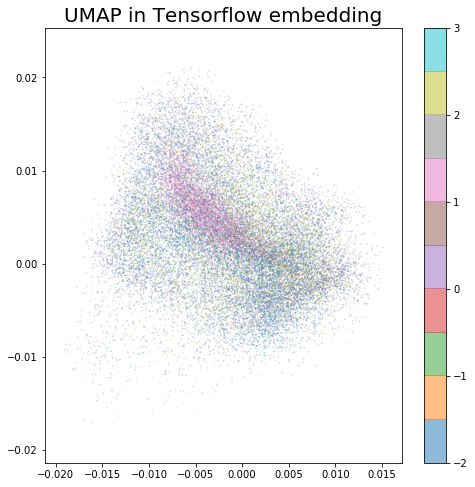

In [32]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [33]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [34]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
['recon_loss']


,wall_time,step,val,group,variable
0,1.594680e+09,1,4.078748,train,umap_loss
1,1.594680e+09,2,2.373842,train,umap_loss
2,1.594680e+09,3,1.691405,train,umap_loss


In [35]:
loss_df.group.unique()

array(['train', 'valid'], dtype=object)

Text(0.5, 1.0, 'Reconstruction loss')

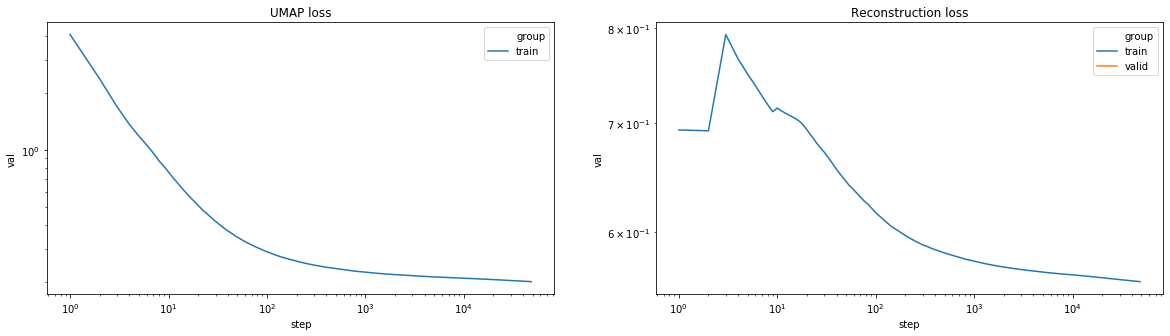

In [36]:
fig, axs = plt.subplots(ncols=2, figsize=(20,5))
ax = axs[0]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'], ax = ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('UMAP loss')

ax = axs[1]
sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='recon_loss'], ax = ax)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Reconstruction loss')

### Save output

In [37]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [38]:
output_dir = MODEL_DIR/'celeba'/ '128_512' 
ensure_dir(output_dir)

In [39]:
#embedder.save(output_dir)

In [40]:
import os

In [41]:
embedder.encoder.save(os.path.join(output_dir, "encoder"))

W0713 17:28:25.476083 140426742949696 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0713 17:28:25.788426 140426742949696 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/celeba/128_512/encoder/assets


In [42]:
import pickle

In [43]:
with open(os.path.join(output_dir, "model.pkl"), "w") as output:
    pickle.dump(embedder, output, protocol=4)

OverflowError: cannot serialize a bytes object larger than 4 GiB

In [64]:
%debug

> /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py(161)should_pickle()
    159         # return True
    160         try:
--> 161             pickle.dumps(val)
    162         except (
    163             pickle.PicklingError,

ipdb> up
> /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py(173)<genexpr>()
    171     def __getstate__(self):
    172         # this function supports pickling, making sure that objects can be pickled
--> 173         return dict((k, v) for (k, v) in self.__dict__.items() if self.should_pickle(v))
    174 
    175     def save(self, save_location, verbose=True):

ipdb> k
'_raw_data'
ipdb> _raw_data.shape
*** NameError: name '_raw_data' is not defined
ipdb> type(_raw_data)
*** NameError: name '_raw_data' is not defined
ipdb> up
> /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/tfumap/umap.py(173)__getstate__()
    171     def __getstate__(self):
    172         # this function supports pickling, making su

In [ ]:
pickle.dump(embedder, open(os.path.join(output_dir, "model.pkl"), 'w'), protocol=4)

In [ ]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [ ]:
np.save(output_dir / 'z.npy', z)

### View reconstructions on test data

In [45]:
print('test')

test


In [44]:
z_test = embedder.transform(X_test)

In [46]:
np.shape(z_test)

(1000, 512)

In [47]:
X_test_recon = embedder.inverse_transform(z_test)

In [48]:
X_test_recon.max()

0.9956169

In [49]:
X_test_recon.min()

0.0017155731

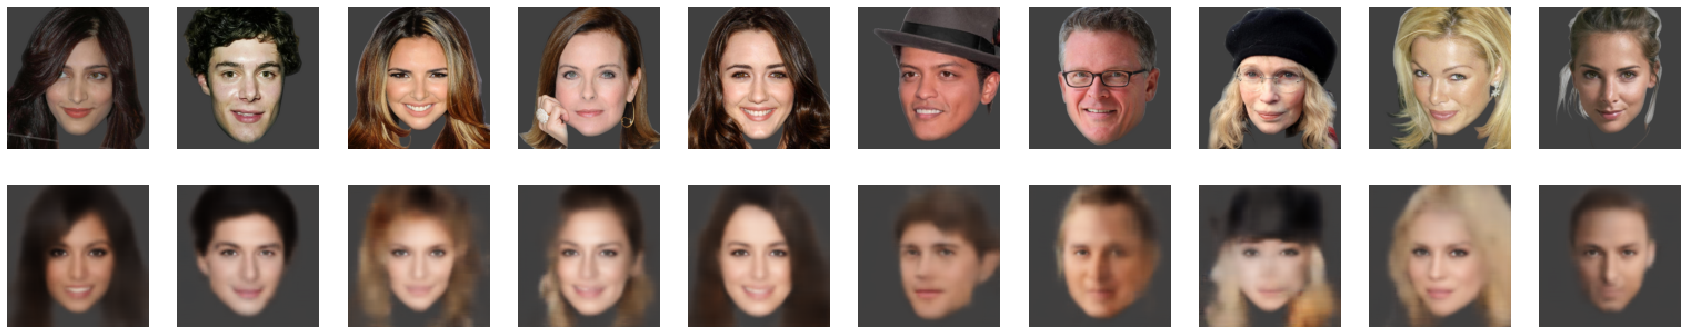

In [50]:
nex = 10
fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(nex*3,2*3))
for i in range(nex):
    axs[0,i].imshow(X_test[i].reshape(128,128,3))
    axs[1,i].imshow(X_test_recon[i].reshape(128,128,3))
for ax in axs.flatten():
    ax.axis('off')

### Interpolations on test data

In [51]:
nex = 10

In [52]:
interp_pts = np.linspace(0, 1, nex)

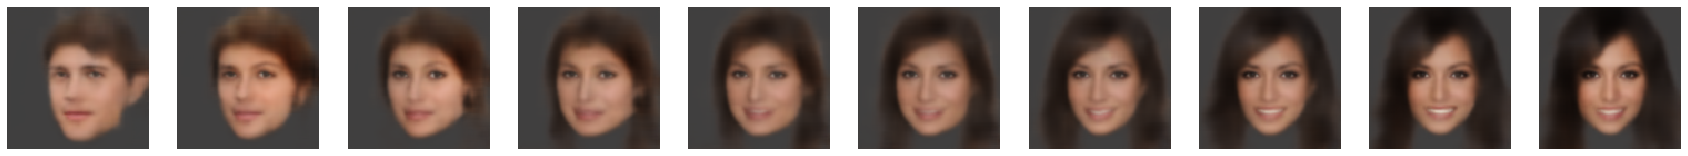

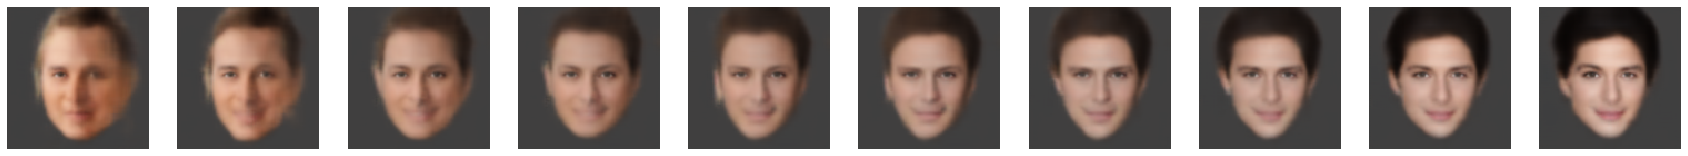

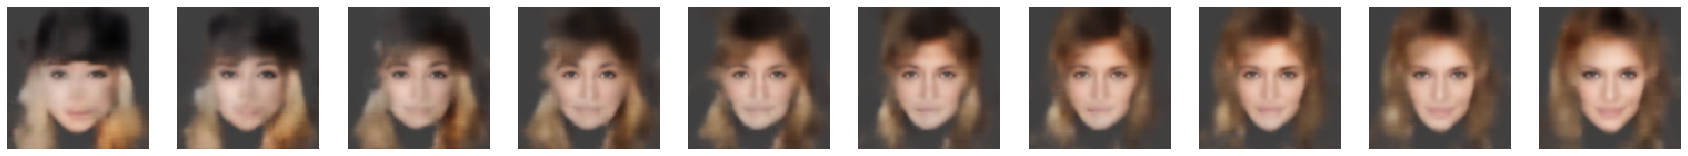

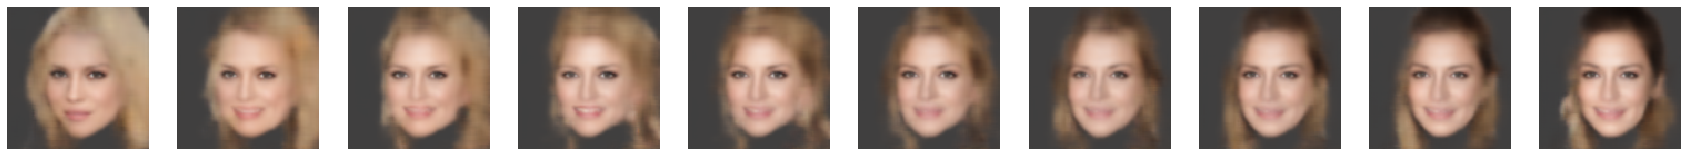

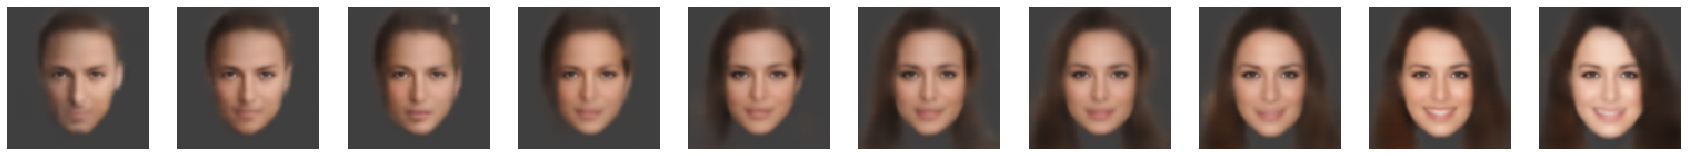

In [53]:
for i,j in zip(np.arange(0,5), np.arange(5,10)):
    z1 = z_test[i]
    z2 = z_test[j]
    z_interp = [z1*i + z2*(1-i) for i in interp_pts]
    x_interp = embedder.inverse_transform(np.array(z_interp))

    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(nex*3,3))
    for i in range(nex):
        axs[i].imshow(x_interp[i].reshape(128,128,3))
    for ax in axs.flatten():
        ax.axis('off')

    plt.show()

### Untangling latent factors

In [54]:
from statsmodels.api import OLS

In [55]:
faces_merged = pd.merge(anno_df, faces_128_df[['face', 'id']], on=['id'])

In [56]:
face_x = np.array(list(faces_merged['face'].values)) / 255.
face_z = embedder.transform(face_x)
face_z.shape

(30000, 512)

In [57]:
all_attr = faces_merged.drop(columns = ['id', 'hair_category', 'face'])
data_labels = 1.0*(all_attr == 1)
data_labels['bias'] = 1.0

In [58]:
model_z = OLS(face_z, data_labels)
result_z = model_z.fit()
result_z.params[:3]

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
5_o_Clock_Shadow,-0.001095,0.001947,0.000319,0.000457,-0.001556,-0.000632,-0.000356,0.000175,0.003466,-0.001215,...,0.000511,-0.124253,-0.003008,-0.002352,-0.000281,-0.001004,-0.001061,-0.000537,0.001376,-0.000328
Arched_Eyebrows,0.000356,0.000431,0.000134,-0.001422,0.001409,0.001281,-0.000538,-0.000958,-0.002841,-0.000215,...,0.001154,-0.041344,0.009102,0.002394,-0.000294,0.001042,0.000586,0.000285,-0.001364,0.001976
Attractive,-0.001096,0.000931,0.000037,0.001802,-0.002506,-0.001759,0.000093,0.001066,0.005562,-0.000305,...,-0.000533,-0.075112,0.012097,-0.003842,-0.000262,-0.001497,-0.001129,-0.000419,0.002316,-0.001576


In [59]:
z_model = result_z.params.values[:-1]
z_labels = list(result_z.params.index)[:-1]
bias = result_z.params.loc['bias'].values

In [65]:
z_labels_bias = np.array([bias + i*1 for i in z_model])
x_labels = embedder.inverse_transform(np.array(z_labels_bias))

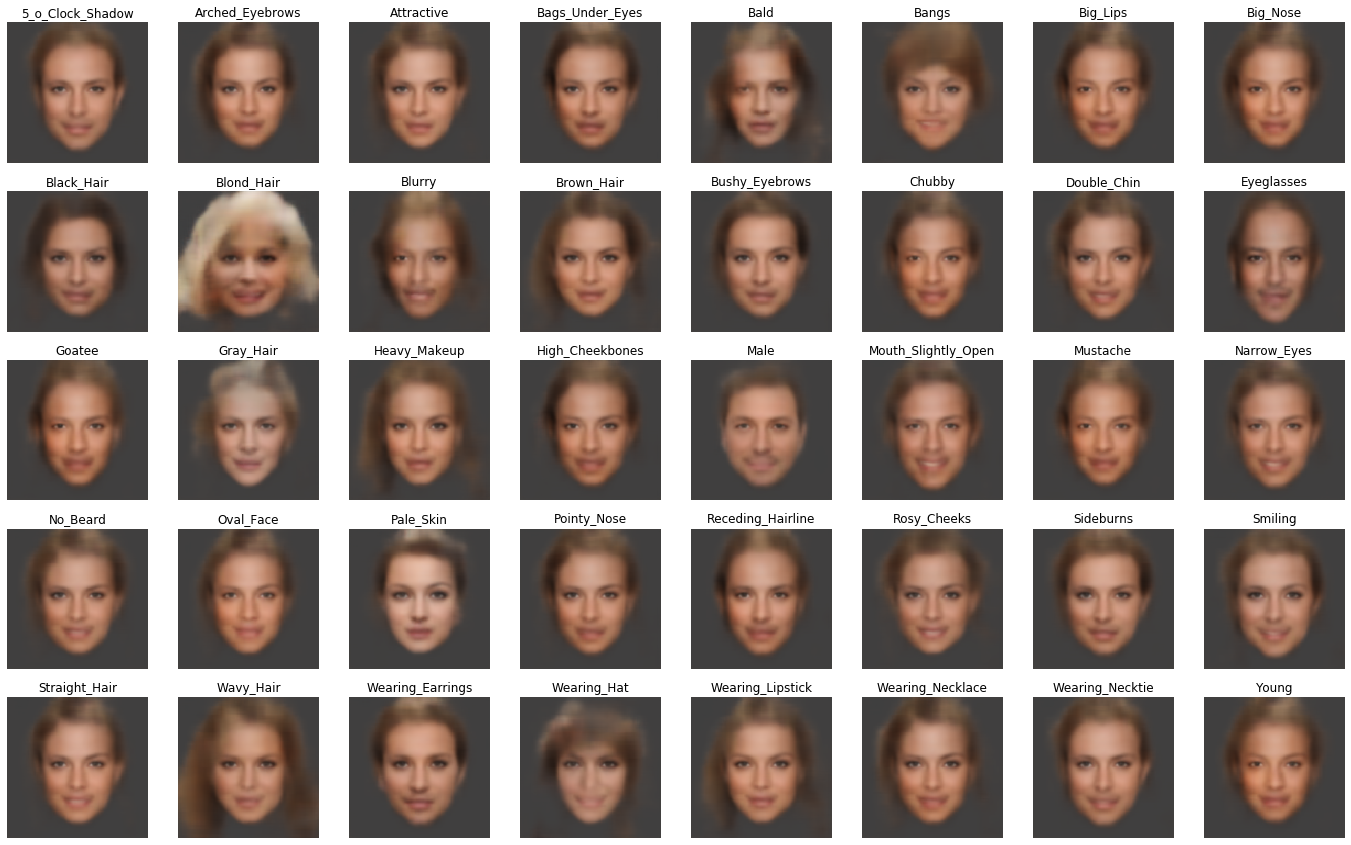

In [66]:
fig, axs = plt.subplots(ncols=8, nrows=5, figsize=(8*3,5*3))
for i, (lab, img) in tqdm(enumerate(zip(z_labels, x_labels))):
    ax = axs.flatten()[i]
    ax.imshow(img)
    ax.set_title(lab)
    ax.axis('off')